<a href="https://colab.research.google.com/github/ChangCorp/finalproject/blob/main/ChangCorp_Stage_2_Version_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# HOMEWORK DATA PRE-PROCESSING

In [1]:
import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder   
import pickle  
from pathlib import Path  

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline 
matplotlib.style.use('ggplot') 


## 1. Data Cleansing

In [2]:
df_train_raw = pd.read_csv('https://raw.githubusercontent.com/ChangCorp/finalproject/main/train_delimited_comma.csv')
df_test_raw = pd.read_csv('https://raw.githubusercontent.com/ChangCorp/finalproject/main/test_delimited_comma.csv')

In [3]:
# menyalin dataset agar tidak mengubah dataset raw
df_train = df_train_raw.copy()
df_test = df_test_raw.copy()

In [4]:
df_train.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [5]:
df_test.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,79,1,-1,0,unknown,no
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220,1,339,4,failure,no
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185,1,330,1,failure,no
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,199,4,-1,0,unknown,no
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,226,1,-1,0,unknown,no


### A. Handle Missing Value

#### 1. TRAIN DATA SET

In [6]:
# mengetahui missing value
df_train.isna().sum()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64

* Tidak ditemukan missing value namun terdapat nilai *unknown* pada kolom `job`, `education`, `contact`, dan `poutcome`. <br>
* Kolom `job`, `education`, `contact` memikliki unknown yang relatif tidak banyak, akan diisi dengan nilai mode. <br>
* Kolom `poutcome` memiliki *unknown* sekitar 37k records, akan di-feature encoding menjadi poutcome_success 0 1, <br>

##### Handling *Unknown* value `job`

In [7]:
df_train1=df_train.groupby(['education','job']).agg({'job':['count']})

df_train1=df_train1.reset_index() #diperlukan supaya bisa ganti nama kolom
df_train1.columns=['education','job','count']
df_train1.head()

,education,job,count
0,primary,admin.,209
1,primary,blue-collar,3758
2,primary,entrepreneur,183
3,primary,housemaid,627
4,primary,management,294


In [8]:
# Mengambil mode job untuk tiap education
df_train1["rank"]=df_train1.groupby('education')['count'].rank(method="dense", ascending=False)
df_train1[df_train1['rank']==1].sort_values(['education'],ascending=[True])

,education,job,count,rank
1,primary,blue-collar,3758,1.0
13,secondary,blue-collar,5371,1.0
28,tertiary,management,7801,1.0
37,unknown,blue-collar,454,1.0


In [9]:
# Nilai unknown pada `job` berubah menyesuaikan data `education`

df_train.loc[(df_train.job == "unknown") & (df_train.education == "primary"),"job"] = "blue-collar"
df_train.loc[(df_train.job == "unknown") & (df_train.education == "secondary"),"job"] = "blue-collar"
df_train.loc[(df_train.job == "unknown") & (df_train.education == "tertiary"),"job"] = "management"
df_train.loc[(df_train.job == "unknown") & (df_train.education == "unknown"),"job"] = "blue-collar"

In [10]:
# Nilai unknown pada `job` berubah menyesuaikan data `education`
df_train["job"].value_counts()

blue-collar      9981
management       9497
technician       7597
admin.           5171
services         4154
retired          2264
self-employed    1579
entrepreneur     1487
unemployed       1303
housemaid        1240
student           938
Name: job, dtype: int64

##### Handling *Unknown* value  `education`

In [11]:
# Mengambil mode education untuk tiap job
df_train1["rank2"]=df_train1.groupby('job')['count'].rank(method="dense", ascending=False)
df_train1[df_train1['rank2']==1].sort_values(['job'],ascending=[True])

,education,job,count,rank,rank2
12,secondary,admin.,4219,3.0,1.0
13,secondary,blue-collar,5371,1.0,1.0
26,tertiary,entrepreneur,686,4.0,1.0
3,primary,housemaid,627,3.0,1.0
28,tertiary,management,7801,1.0,1.0
17,secondary,retired,984,6.0,1.0
30,tertiary,self-employed,833,3.0,1.0
19,secondary,services,3457,4.0,1.0
20,secondary,student,508,10.0,1.0
21,secondary,technician,5229,2.0,1.0


In [12]:
# Nilai unknown pada `education` berubah menyesuaikan data modus pada `job`

df_train.loc[(df_train.education == "unknown") & (df_train.job == "admin."),"education"] = "secondary"
df_train.loc[(df_train.education == "unknown") & (df_train.job == "blue-collar"),"education"] = "secondary"
df_train.loc[(df_train.education == "unknown") & (df_train.job == "entrepreneur"),"education"] = "tertiary"
df_train.loc[(df_train.education == "unknown") & (df_train.job == "housemaid"),"education"] = "primary"
df_train.loc[(df_train.education == "unknown") & (df_train.job == "management"),"education"] = "tertiary"
df_train.loc[(df_train.education == "unknown") & (df_train.job == "retired"),"education"] = "secondary"
df_train.loc[(df_train.education == "unknown") & (df_train.job == "self-employed"),"education"] = "tertiary"
df_train.loc[(df_train.education == "unknown") & (df_train.job == "services"),"education"] = "secondary"
df_train.loc[(df_train.education == "unknown") & (df_train.job == "student"),"education"] = "secondary"
df_train.loc[(df_train.education == "unknown") & (df_train.job == "technician"),"education"] = "secondary"
df_train.loc[(df_train.education == "unknown") & (df_train.job == "unemployed"),"education"] = "secondary"
df_train.loc[(df_train.education == "unknown"),"education"] = "secondary"

In [13]:
df_train["education"].value_counts()

secondary    24657
tertiary     13658
primary       6896
Name: education, dtype: int64

##### Handling *Unknown* value  `contact`

In [14]:
df_train["contact"].replace(["unknown"],df_train["contact"].mode(),inplace = True)

In [15]:
df_train["contact"].value_counts()

cellular     42305
telephone     2906
Name: contact, dtype: int64

##### Insight 
Sudah tidak ada nilai *unknown* pada kolom `education` , `job`, `contact` 

In [16]:
df_train.shape

(45211, 17)

In [17]:
df_test.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,79,1,-1,0,unknown,no
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220,1,339,4,failure,no
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185,1,330,1,failure,no
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,199,4,-1,0,unknown,no
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,226,1,-1,0,unknown,no


#### 2. TEST DATA SET

In [18]:
# mengetahui missing value
df_test.isna().sum()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64

In [19]:
# Nilai unknown pada `job` berubah menyesuaikan data `education`, mengikuti rules dataset Train

df_test.loc[(df_test.job == "unknown") & (df_test.education == "primary"),"job"] = "blue-collar"
df_test.loc[(df_test.job == "unknown") & (df_test.education == "secondary"),"job"] = "blue-collar"
df_test.loc[(df_test.job == "unknown") & (df_test.education == "tertiary"),"job"] = "management"
df_test.loc[(df_test.job == "unknown") & (df_test.education == "unknown"),"job"] = "blue-collar"

In [20]:
# Nilai unknown pada `education` berubah menyesuaikan data modus pada `job`, mengikuti rules dataset Train

df_test.loc[(df_test.education == "unknown") & (df_test.job == "admin."),"education"] = "secondary"
df_test.loc[(df_test.education == "unknown") & (df_test.job == "blue-collar"),"education"] = "secondary"
df_test.loc[(df_test.education == "unknown") & (df_test.job == "entrepreneur"),"education"] = "tertiary"
df_test.loc[(df_test.education == "unknown") & (df_test.job == "housemaid"),"education"] = "primary"
df_test.loc[(df_test.education == "unknown") & (df_test.job == "management"),"education"] = "tertiary"
df_test.loc[(df_test.education == "unknown") & (df_test.job == "retired"),"education"] = "secondary"
df_test.loc[(df_test.education == "unknown") & (df_test.job == "self-employed"),"education"] = "tertiary"
df_test.loc[(df_test.education == "unknown") & (df_test.job == "services"),"education"] = "secondary"
df_test.loc[(df_test.education == "unknown") & (df_test.job == "student"),"education"] = "secondary"
df_test.loc[(df_test.education == "unknown") & (df_test.job == "technician"),"education"] = "secondary"
df_test.loc[(df_test.education == "unknown") & (df_test.job == "unemployed"),"education"] = "secondary"
df_test.loc[(df_test.education == "unknown"),"education"] = "secondary"

In [21]:
df_test["contact"].replace(["unknown"],df_test["contact"].mode(),inplace = True)

##### Insight 
Sudah tidak ada nilai *unknown* pada kolom `education` , `job`, `contact

### B. Handle Duplicate Data

#### 1. TRAIN DATA SET

In [22]:
# mengetahui jumlah baris yang duplicated terhadap semua kolom
print('Jumlah baris duplicate: ', df_train.duplicated().sum())

Jumlah baris duplicate:  0


##### Insight

Tidak ada data yang duplikat sehingga tidak dilakukan drop duplicates

#### 2. TEST DATA SET

In [23]:
# mengetahui jumlah baris yang duplicated terhadap semua kolom
print('Jumlah baris duplicate: ', df_test.duplicated().sum())

Jumlah baris duplicate:  0


##### Insight

Tidak ada data yang duplikat sehingga tidak dilakukan drop duplicates

### C. FEATURE ENCODING

In [24]:
le=LabelEncoder()
df_train['y']=le.fit_transform(df_train['y'])

In [25]:
df_train = pd.get_dummies(df_train, columns=['job'], prefix='job')
df_train

,age,marital,education,default,balance,housing,loan,contact,day,month,...,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed
0,58,married,tertiary,no,2143,yes,no,cellular,5,may,...,0,0,0,1,0,0,0,0,0,0
1,44,single,secondary,no,29,yes,no,cellular,5,may,...,0,0,0,0,0,0,0,0,1,0
2,33,married,secondary,no,2,yes,yes,cellular,5,may,...,0,1,0,0,0,0,0,0,0,0
3,47,married,secondary,no,1506,yes,no,cellular,5,may,...,1,0,0,0,0,0,0,0,0,0
4,33,single,secondary,no,1,no,no,cellular,5,may,...,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,51,married,tertiary,no,825,no,no,cellular,17,nov,...,0,0,0,0,0,0,0,0,1,0
45207,71,divorced,primary,no,1729,no,no,cellular,17,nov,...,0,0,0,0,1,0,0,0,0,0
45208,72,married,secondary,no,5715,no,no,cellular,17,nov,...,0,0,0,0,1,0,0,0,0,0
45209,57,married,secondary,no,668,no,no,telephone,17,nov,...,1,0,0,0,0,0,0,0,0,0


In [26]:
#applying label encoder on categorical columns
df_train['n_marital']=le.fit_transform(df_train['marital'])
df_train['n_education']=le.fit_transform(df_train['education'])
df_train['n_loan']=le.fit_transform(df_train['loan'])
df_train['n_contact']=le.fit_transform(df_train['contact'])
df_train['n_month']=le.fit_transform(df_train['month'])
df_train['n_poutcome']=le.fit_transform(df_train['poutcome'])
df_train['n_y']=df_train['y']

In [27]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 34 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   age                45211 non-null  int64 
 1   marital            45211 non-null  object
 2   education          45211 non-null  object
 3   default            45211 non-null  object
 4   balance            45211 non-null  int64 
 5   housing            45211 non-null  object
 6   loan               45211 non-null  object
 7   contact            45211 non-null  object
 8   day                45211 non-null  int64 
 9   month              45211 non-null  object
 10  duration           45211 non-null  int64 
 11  campaign           45211 non-null  int64 
 12  pdays              45211 non-null  int64 
 13  previous           45211 non-null  int64 
 14  poutcome           45211 non-null  object
 15  y                  45211 non-null  int64 
 16  job_admin.         45211 non-null  uint8

### D. Handle Outliers

Dataset yang di handling outliers hanya data train, sedangkan data test tidak 

#### Outlier detection

In [29]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 34 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   age                45211 non-null  int64 
 1   marital            45211 non-null  object
 2   education          45211 non-null  object
 3   default            45211 non-null  object
 4   balance            45211 non-null  int64 
 5   housing            45211 non-null  object
 6   loan               45211 non-null  object
 7   contact            45211 non-null  object
 8   day                45211 non-null  int64 
 9   month              45211 non-null  object
 10  duration           45211 non-null  int64 
 11  campaign           45211 non-null  int64 
 12  pdays              45211 non-null  int64 
 13  previous           45211 non-null  int64 
 14  poutcome           45211 non-null  object
 15  y                  45211 non-null  int64 
 16  job_admin.         45211 non-null  uint8

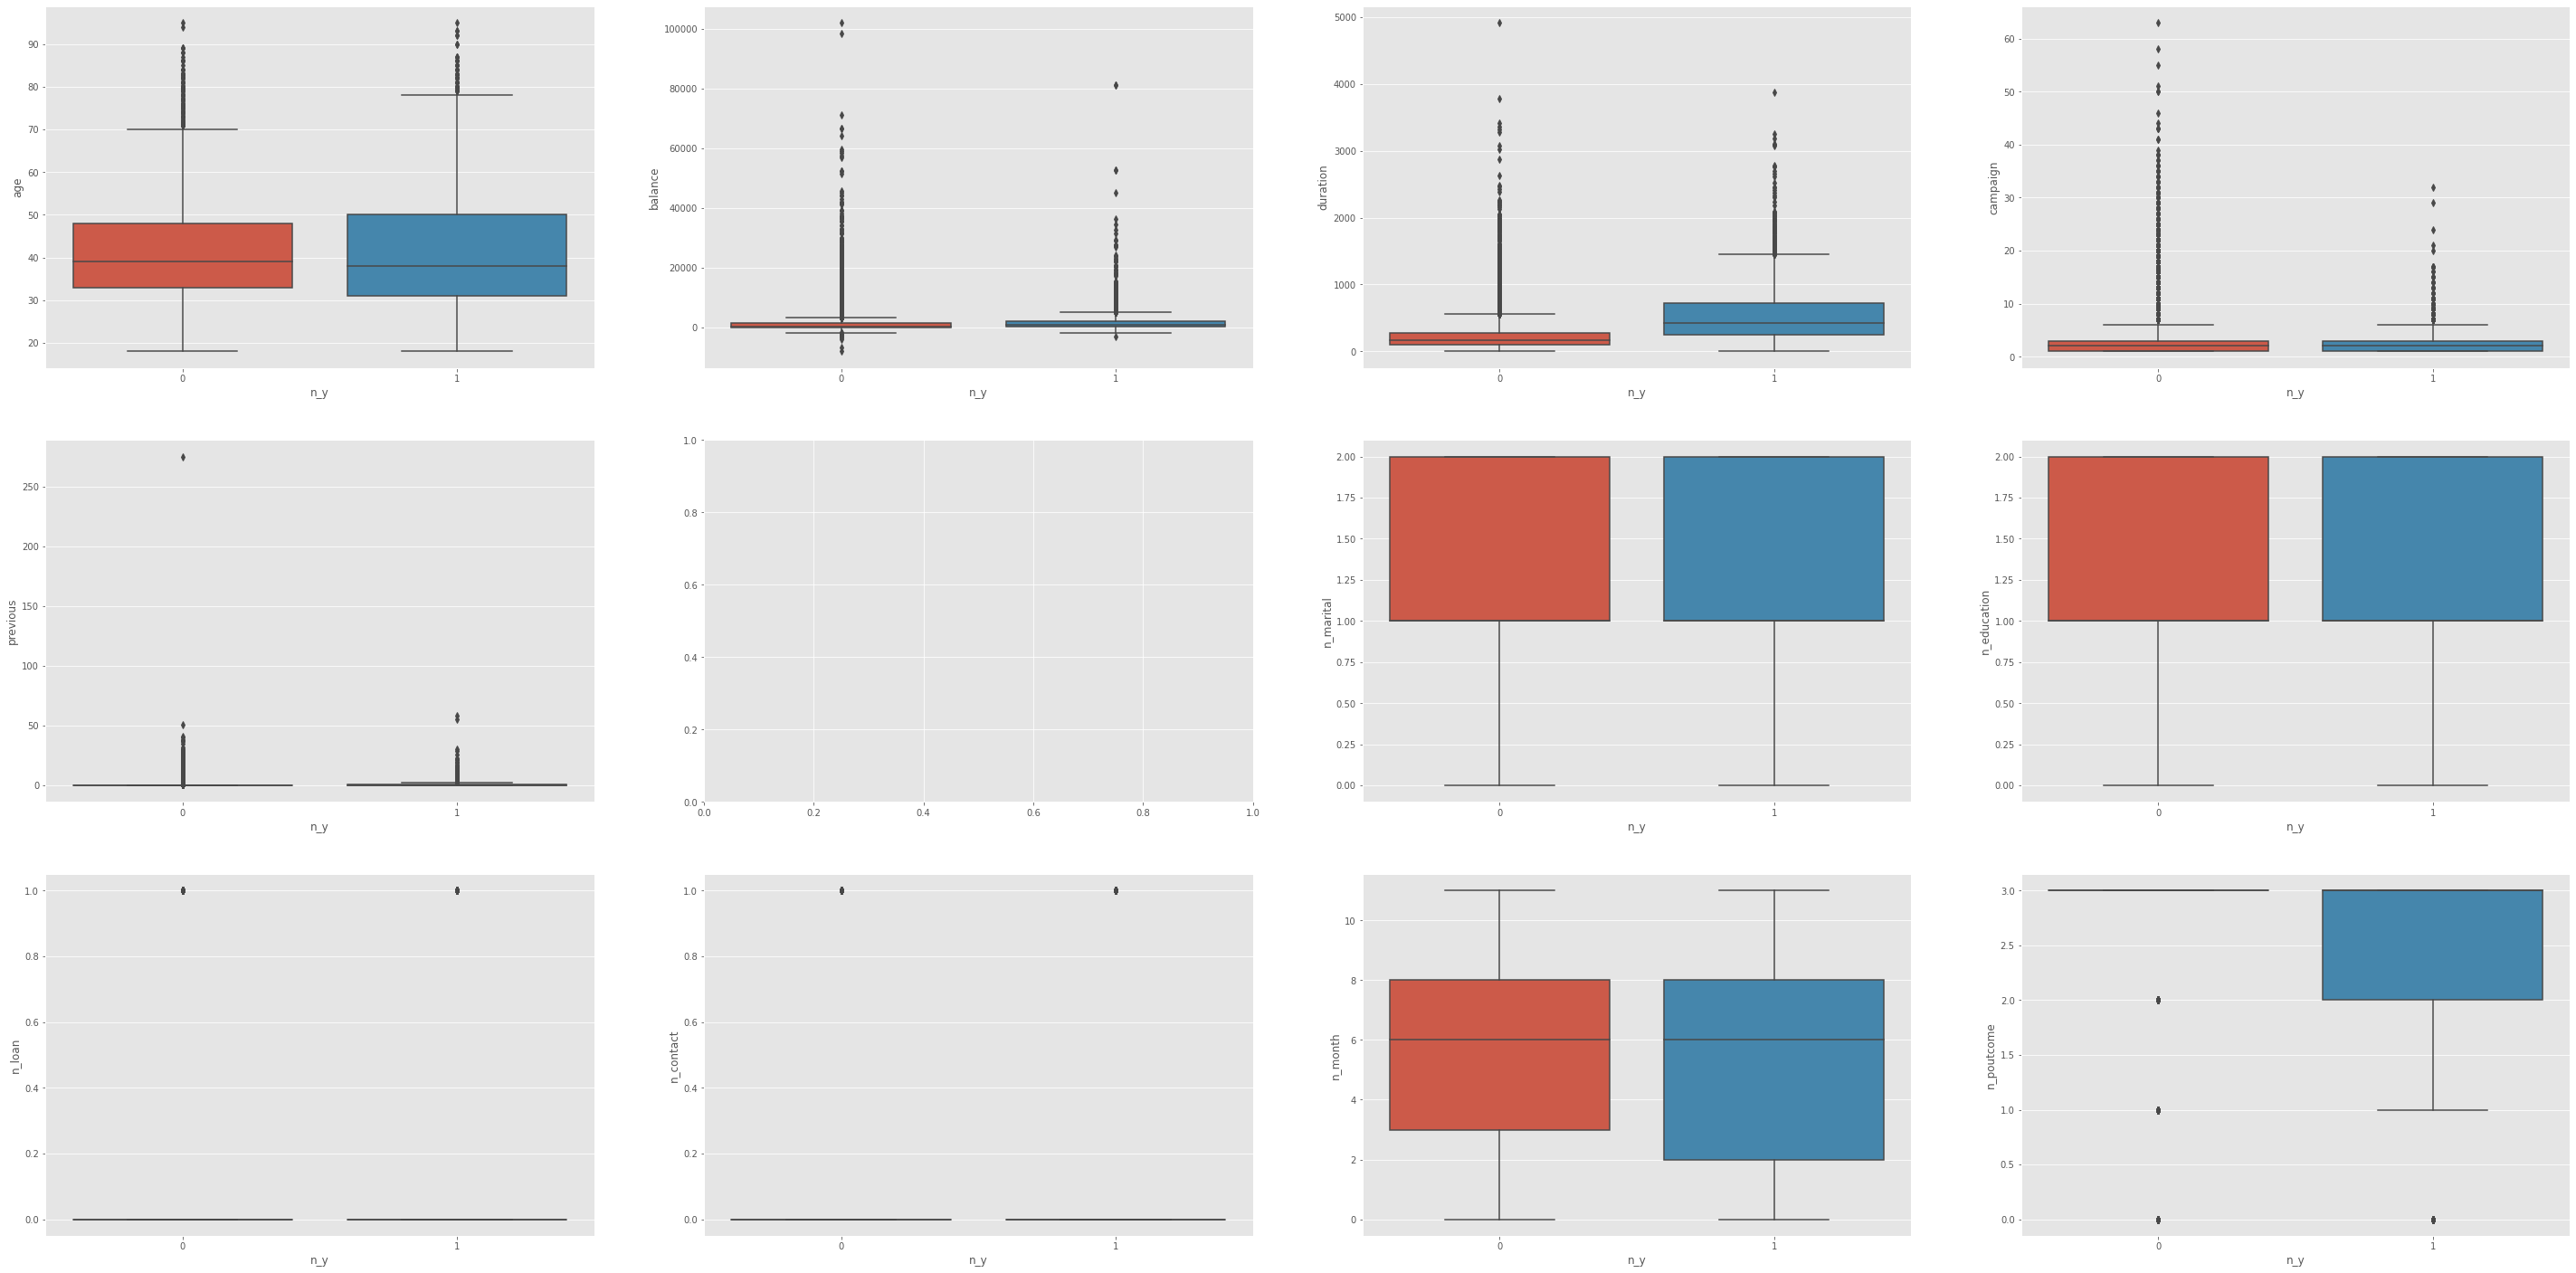

In [30]:
figure, axis = plt.subplots(3, 4, figsize = (50,25))
sns.boxplot(x='n_y',y='age',data=df_train,ax=axis[0,0])
sns.boxplot(x='n_y',y='balance',data=df_train,ax=axis[0,1])
sns.boxplot(x='n_y',y='duration',data=df_train,ax=axis[0,2])
sns.boxplot(x='n_y',y='campaign',data=df_train,ax=axis[0,3])
sns.boxplot(x='n_y',y='previous',data=df_train,ax=axis[1,0])
sns.boxplot(x='n_y',y='n_marital',data=df_train,ax=axis[1,2])
sns.boxplot(x='n_y',y='n_education',data=df_train,ax=axis[1,3])
sns.boxplot(x='n_y',y='n_loan',data=df_train,ax=axis[2,0])
sns.boxplot(x='n_y',y='n_contact',data=df_train,ax=axis[2,1])
sns.boxplot(x='n_y',y='n_month',data=df_train,ax=axis[2,2])
sns.boxplot(x='n_y',y='n_poutcome',data=df_train,ax=axis[2,3])

#### Outlier removal

In [31]:
#shows all record whose deposit value is 0 
outcome_zero=df_train[df_train['n_y'] == 0]
outcome_zero

#shows all record whose deposit value is 1
outcome_one=df_train[df_train['n_y'] == 1]
outcome_one

,age,marital,education,default,balance,housing,loan,contact,day,month,...,job_student,job_technician,job_unemployed,n_marital,n_education,n_loan,n_contact,n_month,n_poutcome,n_y
83,59,married,secondary,no,2343,yes,no,cellular,5,may,...,0,0,0,1,1,0,0,8,3,1
86,56,married,secondary,no,45,no,no,cellular,5,may,...,0,0,0,1,1,0,0,8,3,1
87,41,married,secondary,no,1270,yes,no,cellular,5,may,...,0,1,0,1,1,0,0,8,3,1
129,55,married,secondary,no,2476,yes,no,cellular,5,may,...,0,0,0,1,1,0,0,8,3,1
168,54,married,tertiary,no,184,no,no,cellular,5,may,...,0,0,0,1,2,0,0,8,3,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45204,73,married,secondary,no,2850,no,no,cellular,17,nov,...,0,0,0,1,1,0,0,9,0,1
45205,25,single,secondary,no,505,no,yes,cellular,17,nov,...,0,1,0,2,1,1,0,9,3,1
45206,51,married,tertiary,no,825,no,no,cellular,17,nov,...,0,1,0,1,2,0,0,9,3,1
45207,71,divorced,primary,no,1729,no,no,cellular,17,nov,...,0,0,0,0,0,0,0,9,3,1


In [32]:
## OUTCOME ZERO ##

def Outdet(df_train):
    Q1=df_train.quantile(0.25)
    Q3=df_train.quantile(0.75)
    IQR=Q3-Q1
    LR=Q1-(IQR*1.5)
    UR=Q3+(IQR*1.5)
    return LR,UR

LR,UR=Outdet(outcome_zero.age)
print(LR,UR)

#removing outliers from feature(age)
outcome_zero=outcome_zero[(outcome_zero['age'] > LR)  &  (outcome_zero['age'] < UR)]
outcome_zero

#balance
LR,UR=Outdet(outcome_zero.balance)
print(LR,UR)
outcome_zero=outcome_zero[(outcome_zero['balance']>LR) & (outcome_zero['balance']< UR)]
outcome_zero

#day
LR,UR=Outdet(outcome_zero.day)
print(LR,UR)
outcome_zero=outcome_zero[(outcome_zero['day']>LR) & (outcome_zero['day']< UR)]
outcome_zero

#duration
LR,UR=Outdet(outcome_zero.duration)
print(LR,UR)
outcome_zero=outcome_zero[(outcome_zero['duration']>LR) & (outcome_zero['duration']< UR)]
outcome_zero

#campaign
LR,UR=Outdet(outcome_zero.campaign)
print(LR,UR)
outcome_zero=outcome_zero[(outcome_zero['campaign']>LR) & (outcome_zero['campaign']< UR)]
outcome_zero

#balance
LR,UR=Outdet(outcome_zero.balance)
print(LR,UR)
outcome_zero=outcome_zero[(outcome_zero['balance']>LR) & (outcome_zero['balance']< UR)]
outcome_zero

#duration
LR,UR=Outdet(outcome_zero.duration)
print(LR,UR)
outcome_zero=outcome_zero[(outcome_zero['duration']>LR) & (outcome_zero['duration']< UR)]
outcome_zero


10.5 70.5
-1859.0 3253.0
-11.5 40.5
-178.0 550.0
-2.0 6.0
-1266.5 2201.5
-140.0 492.0


,age,marital,education,default,balance,housing,loan,contact,day,month,...,job_student,job_technician,job_unemployed,n_marital,n_education,n_loan,n_contact,n_month,n_poutcome,n_y
0,58,married,tertiary,no,2143,yes,no,cellular,5,may,...,0,0,0,1,2,0,0,8,3,0
1,44,single,secondary,no,29,yes,no,cellular,5,may,...,0,1,0,2,1,0,0,8,3,0
2,33,married,secondary,no,2,yes,yes,cellular,5,may,...,0,0,0,1,1,1,0,8,3,0
3,47,married,secondary,no,1506,yes,no,cellular,5,may,...,0,0,0,1,1,0,0,8,3,0
4,33,single,secondary,no,1,no,no,cellular,5,may,...,0,0,0,2,1,0,0,8,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45184,63,married,secondary,no,1495,no,no,cellular,16,nov,...,0,0,0,1,1,0,0,9,2,0
45186,59,married,secondary,no,1500,no,no,cellular,16,nov,...,0,0,0,1,1,0,0,9,0,0
45189,25,single,secondary,no,199,no,no,cellular,16,nov,...,0,0,0,2,1,0,0,9,0,0
45194,59,married,tertiary,no,138,yes,yes,cellular,16,nov,...,0,0,0,1,2,1,0,9,0,0


In [33]:
## OUTCOME ONE ##

#age
LR,UR=Outdet(outcome_one.age)
print(LR,UR)
outcome_one=outcome_one[(outcome_one['age']>LR) & (outcome_one['age']< UR)]
outcome_one

#balance
LR,UR=Outdet(outcome_one.balance)
print(LR,UR)
outcome_one=outcome_one[(outcome_one['balance']>LR) & (outcome_one['balance']< UR)]
outcome_one

#day
LR,UR=Outdet(outcome_one.day)
print(LR,UR)
outcome_one=outcome_one[(outcome_one['day']>LR) & (outcome_one['day']< UR)]
outcome_one

#duration
LR,UR=Outdet(outcome_one.duration)
print(LR,UR)
outcome_one=outcome_one[(outcome_one['duration']>LR) & (outcome_one['duration']< UR)]
outcome_one

#campaign
LR,UR=Outdet(outcome_one.campaign)
print(LR,UR)
outcome_one=outcome_one[(outcome_one['campaign']>LR) & (outcome_one['campaign']< UR)]
outcome_one

#poutcome
LR,UR=Outdet(outcome_one.n_poutcome)
print(LR,UR)
outcome_one=outcome_one[(outcome_one['n_poutcome']>LR) & (outcome_one['n_poutcome']< UR)]
outcome_one

2.5 78.5
-2712.25 5071.75
-11.5 40.5
-478.0 1450.0
-0.5 3.5
0.5 4.5


,age,marital,education,default,balance,housing,loan,contact,day,month,...,job_student,job_technician,job_unemployed,n_marital,n_education,n_loan,n_contact,n_month,n_poutcome,n_y
83,59,married,secondary,no,2343,yes,no,cellular,5,may,...,0,0,0,1,1,0,0,8,3,1
87,41,married,secondary,no,1270,yes,no,cellular,5,may,...,0,1,0,1,1,0,0,8,3,1
129,55,married,secondary,no,2476,yes,no,cellular,5,may,...,0,0,0,1,1,0,0,8,3,1
168,54,married,tertiary,no,184,no,no,cellular,5,may,...,0,0,0,1,2,0,0,8,3,1
270,42,single,tertiary,no,0,yes,yes,cellular,5,may,...,0,0,0,2,2,1,0,8,3,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45202,34,single,secondary,no,557,no,no,cellular,17,nov,...,0,0,0,2,1,0,0,9,3,1
45203,23,single,tertiary,no,113,no,no,cellular,17,nov,...,1,0,0,2,2,0,0,9,3,1
45205,25,single,secondary,no,505,no,yes,cellular,17,nov,...,0,1,0,2,1,1,0,9,3,1
45206,51,married,tertiary,no,825,no,no,cellular,17,nov,...,0,1,0,1,2,0,0,9,3,1


In [34]:
df_train_clean = pd.concat([outcome_zero,outcome_one],axis=0)
df_train_clean

,age,marital,education,default,balance,housing,loan,contact,day,month,...,job_student,job_technician,job_unemployed,n_marital,n_education,n_loan,n_contact,n_month,n_poutcome,n_y
0,58,married,tertiary,no,2143,yes,no,cellular,5,may,...,0,0,0,1,2,0,0,8,3,0
1,44,single,secondary,no,29,yes,no,cellular,5,may,...,0,1,0,2,1,0,0,8,3,0
2,33,married,secondary,no,2,yes,yes,cellular,5,may,...,0,0,0,1,1,1,0,8,3,0
3,47,married,secondary,no,1506,yes,no,cellular,5,may,...,0,0,0,1,1,0,0,8,3,0
4,33,single,secondary,no,1,no,no,cellular,5,may,...,0,0,0,2,1,0,0,8,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45202,34,single,secondary,no,557,no,no,cellular,17,nov,...,0,0,0,2,1,0,0,9,3,1
45203,23,single,tertiary,no,113,no,no,cellular,17,nov,...,1,0,0,2,2,0,0,9,3,1
45205,25,single,secondary,no,505,no,yes,cellular,17,nov,...,0,1,0,2,1,1,0,9,3,1
45206,51,married,tertiary,no,825,no,no,cellular,17,nov,...,0,1,0,1,2,0,0,9,3,1


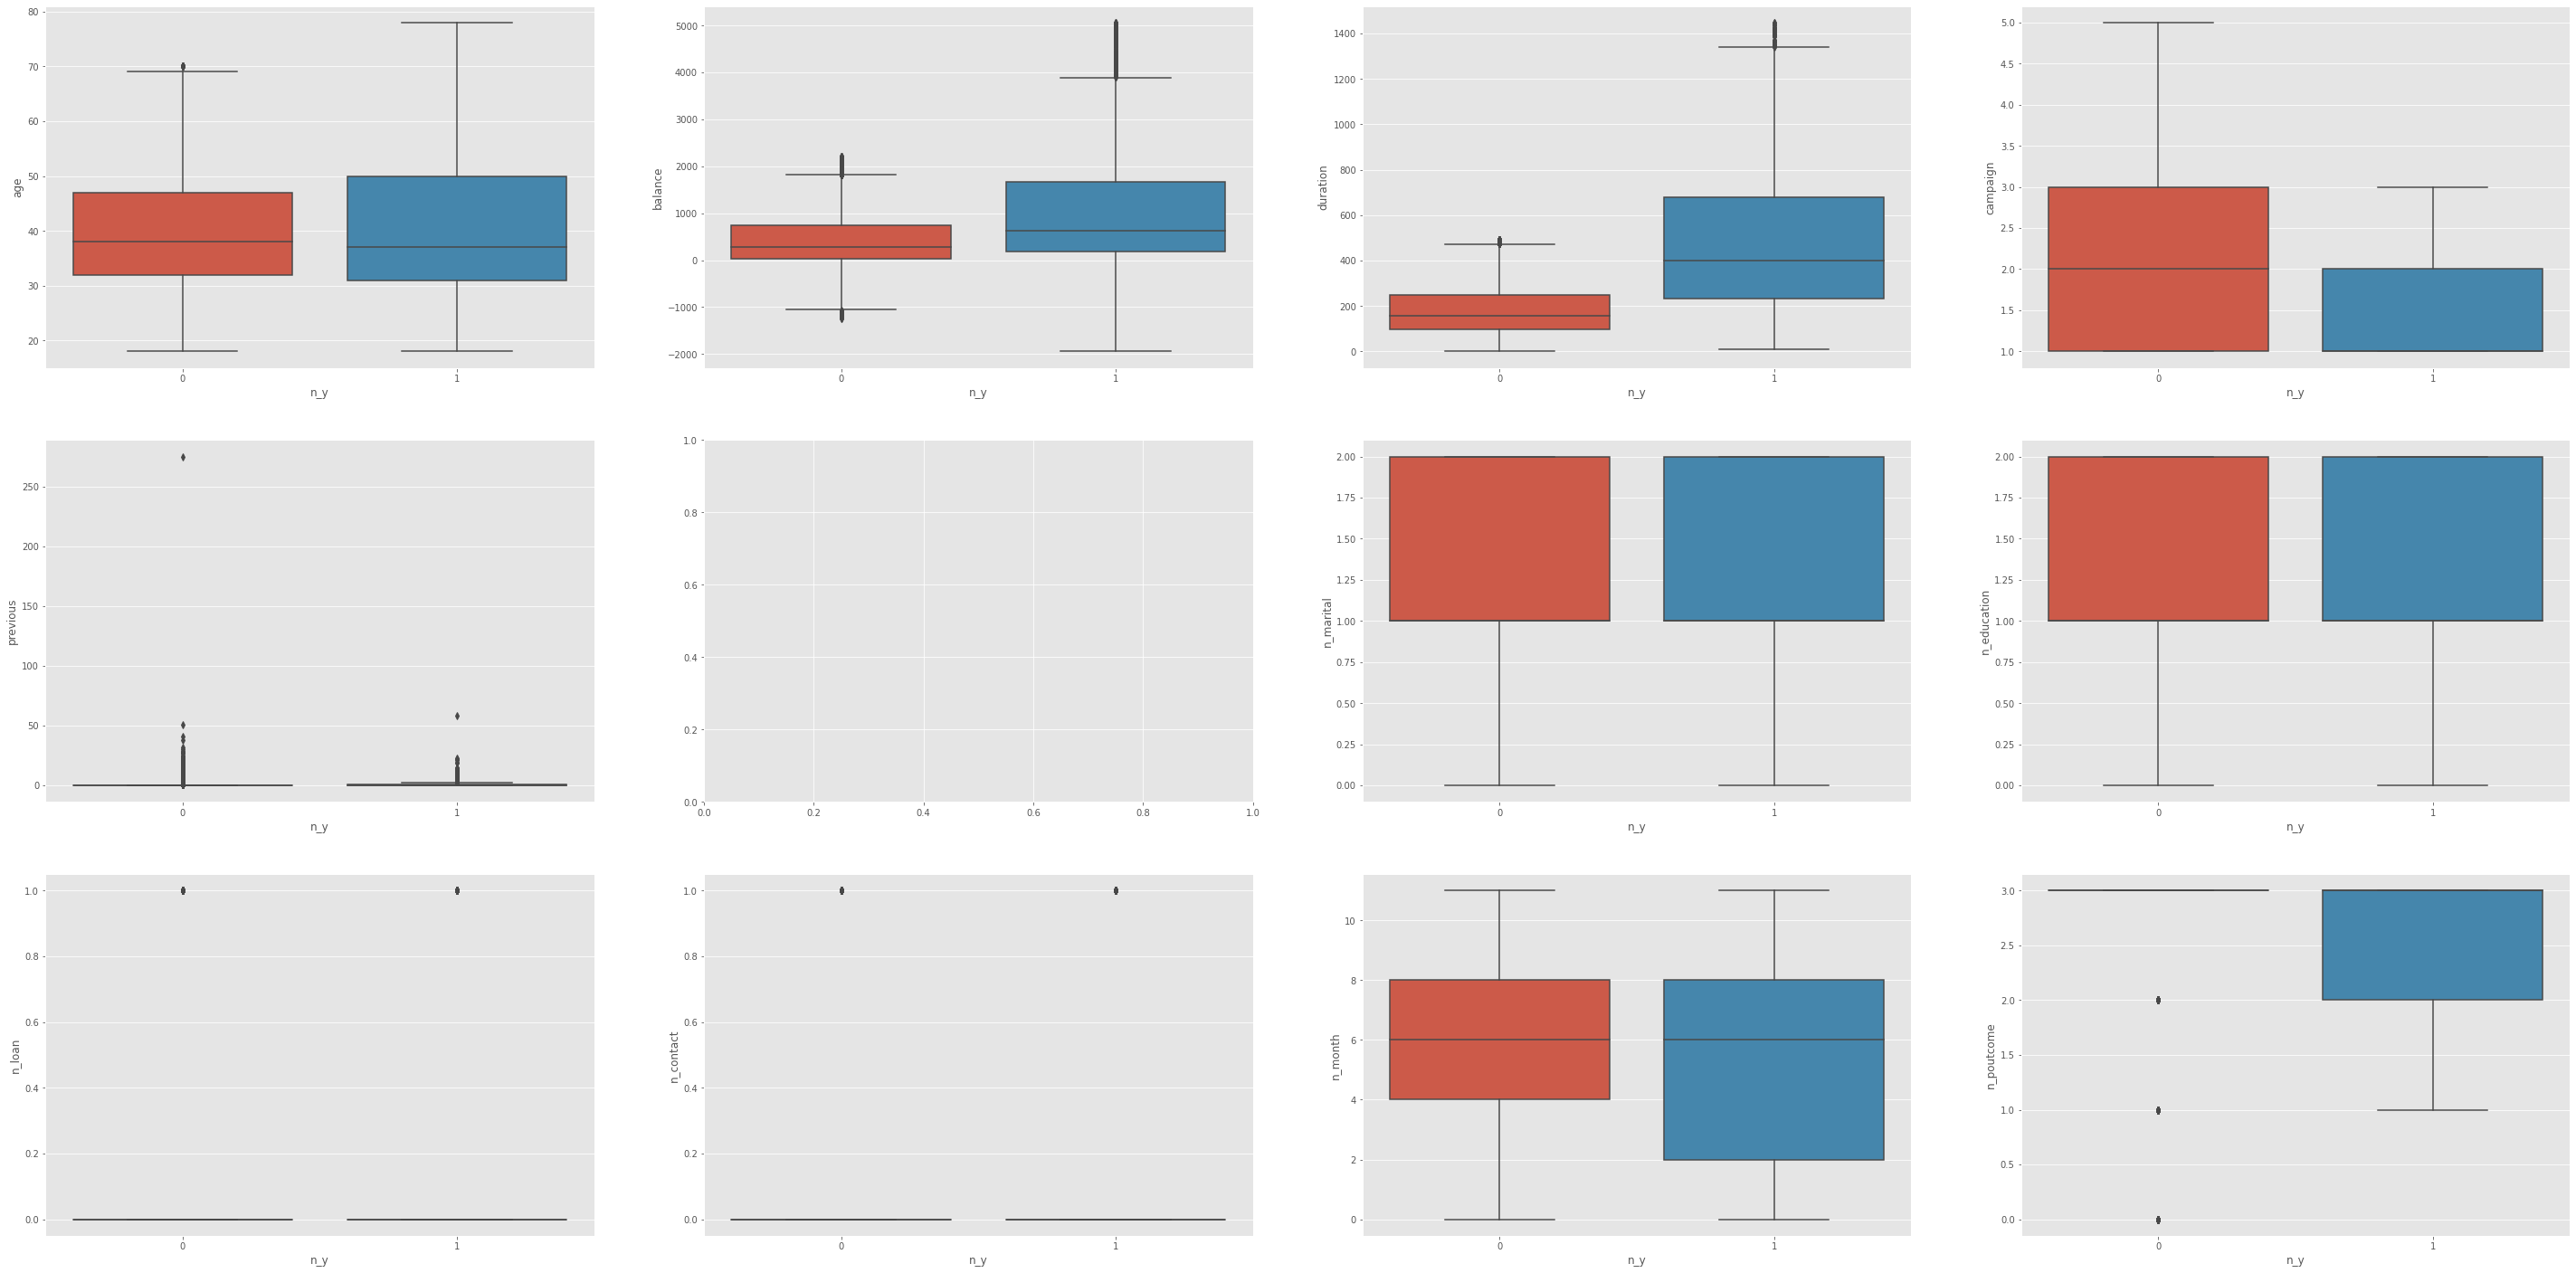

In [35]:
figure, axis = plt.subplots(3, 4, figsize = (50,25))
sns.boxplot(x='n_y',y='age',data=df_train_clean,ax=axis[0,0])
sns.boxplot(x='n_y',y='balance',data=df_train_clean,ax=axis[0,1])
sns.boxplot(x='n_y',y='duration',data=df_train_clean,ax=axis[0,2])
sns.boxplot(x='n_y',y='campaign',data=df_train_clean,ax=axis[0,3])
sns.boxplot(x='n_y',y='previous',data=df_train_clean,ax=axis[1,0])
sns.boxplot(x='n_y',y='n_marital',data=df_train_clean,ax=axis[1,2])
sns.boxplot(x='n_y',y='n_education',data=df_train_clean,ax=axis[1,3])
sns.boxplot(x='n_y',y='n_loan',data=df_train_clean,ax=axis[2,0])
sns.boxplot(x='n_y',y='n_contact',data=df_train_clean,ax=axis[2,1])
sns.boxplot(x='n_y',y='n_month',data=df_train_clean,ax=axis[2,2])
sns.boxplot(x='n_y',y='n_poutcome',data=df_train_clean,ax=axis[2,3])

#### Insight

In [36]:
print(f'Jumlah baris sebelum memfilter outlier: {len(df_train_raw)}')
print(f'Jumlah baris setelah memfilter outlier: {len(df_train_clean)}')

Jumlah baris sebelum memfilter outlier: 45211
Jumlah baris setelah memfilter outlier: 30873


In [37]:
df_train_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30873 entries, 0 to 45207
Data columns (total 34 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   age                30873 non-null  int64 
 1   marital            30873 non-null  object
 2   education          30873 non-null  object
 3   default            30873 non-null  object
 4   balance            30873 non-null  int64 
 5   housing            30873 non-null  object
 6   loan               30873 non-null  object
 7   contact            30873 non-null  object
 8   day                30873 non-null  int64 
 9   month              30873 non-null  object
 10  duration           30873 non-null  int64 
 11  campaign           30873 non-null  int64 
 12  pdays              30873 non-null  int64 
 13  previous           30873 non-null  int64 
 14  poutcome           30873 non-null  object
 15  y                  30873 non-null  int64 
 16  job_admin.         30873 non-null  uint8

### D. Feature Transformation

Feature Tranformation menggunakan Normalizing/standardizing

In [38]:
# Age
from sklearn.preprocessing import MinMaxScaler, StandardScaler
df_train_clean['age_norm'] = MinMaxScaler().fit_transform(df_train_clean['age'].values.reshape(len(df_train_clean),1))
df_train_clean['age_std'] = StandardScaler().fit_transform(df_train_clean['age'].values.reshape(len(df_train_clean),1))
print(df_train_clean[['age','age_norm','age_std']].describe())
print('')
# Day
from sklearn.preprocessing import MinMaxScaler, StandardScaler
df_train_clean['day_norm'] = MinMaxScaler().fit_transform(df_train_clean['day'].values.reshape(len(df_train_clean),1))
df_train_clean['day_std'] = StandardScaler().fit_transform(df_train_clean['day'].values.reshape(len(df_train_clean),1))
print(df_train_clean[['day','day_norm','day_std']].describe())
print('')
# Balance
from sklearn.preprocessing import MinMaxScaler, StandardScaler
df_train_clean['balance_norm'] = MinMaxScaler().fit_transform(df_train_clean['balance'].values.reshape(len(df_train_clean),1))
df_train_clean['balance_std'] = StandardScaler().fit_transform(df_train_clean['balance'].values.reshape(len(df_train_clean),1))
print(df_train_clean[['balance','balance_norm','balance_std']].describe())
print('')
# Duration
from sklearn.preprocessing import MinMaxScaler, StandardScaler
df_train_clean['duration_norm'] = MinMaxScaler().fit_transform(df_train_clean['duration'].values.reshape(len(df_train_clean),1))
df_train_clean['duration_std'] = StandardScaler().fit_transform(df_train_clean['duration'].values.reshape(len(df_train_clean),1))
print(df_train_clean[['duration','duration_norm','duration_std']].describe())
print('')
# Campaign
from sklearn.preprocessing import MinMaxScaler, StandardScaler
df_train_clean['campaign_norm'] = MinMaxScaler().fit_transform(df_train_clean['campaign'].values.reshape(len(df_train_clean),1))
df_train_clean['campaign_std'] = StandardScaler().fit_transform(df_train_clean['campaign'].values.reshape(len(df_train_clean),1))
print(df_train_clean[['campaign','campaign_norm','campaign_std']].describe())
print('')
# Pdays
from sklearn.preprocessing import MinMaxScaler, StandardScaler
df_train_clean['pdays_norm'] = MinMaxScaler().fit_transform(df_train_clean['pdays'].values.reshape(len(df_train_clean),1))
df_train_clean['pdays_std'] = StandardScaler().fit_transform(df_train_clean['pdays'].values.reshape(len(df_train_clean),1))
print(df_train_clean[['pdays','pdays_norm','pdays_std']].describe())
print('')
# Previous
from sklearn.preprocessing import MinMaxScaler, StandardScaler
df_train_clean['previous_norm'] = MinMaxScaler().fit_transform(df_train_clean['previous'].values.reshape(len(df_train_clean),1))
df_train_clean['previous_std'] = StandardScaler().fit_transform(df_train_clean['previous'].values.reshape(len(df_train_clean),1))
print(df_train_clean[['previous','previous_norm','previous_std']].describe())
print('')

                age      age_norm       age_std
count  30873.000000  30873.000000  3.087300e+04
mean      40.251320      0.370855  3.682403e-18
std       10.106233      0.168437  1.000016e+00
min       18.000000      0.000000 -2.201778e+00
25%       32.000000      0.233333 -8.164717e-01
50%       38.000000      0.333333 -2.227691e-01
75%       48.000000      0.500000  7.667353e-01
max       78.000000      1.000000  3.735248e+00

                day      day_norm       day_std
count  30873.000000  30873.000000  3.087300e+04
mean      15.363262      0.478775  5.707725e-17
std        8.322871      0.277429  1.000016e+00
min        1.000000      0.000000 -1.725786e+00
25%        8.000000      0.233333 -8.847165e-01
50%       15.000000      0.466667 -4.364699e-02
75%       21.000000      0.666667  6.772698e-01
max       31.000000      1.000000  1.878798e+00

            balance  balance_norm   balance_std
count  30873.000000  30873.000000  3.087300e+04
mean     526.179121      0.352530  4.4

Feature Transformation menggunakan Log Transformation

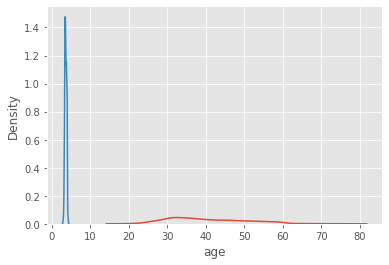

In [39]:
# Age

# distribusi age (nilai asli)
sns.kdeplot(df_train_clean['age'])
# distribusi age (setelah log transformation)
sns.kdeplot(np.log(df_train_clean['age']))
# transformasi
df_train_clean['log_age'] = np.log(df_train_clean['age'])
# drop kolom age (nilai asli)
#df_train_clean = df_train_clean.drop(columns='age')

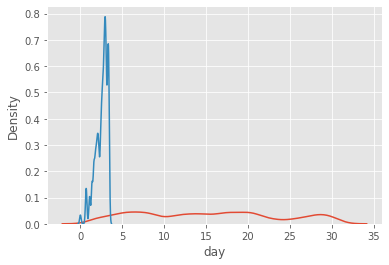

In [40]:
# Day

# distribusi day (nilai asli)
sns.kdeplot(df_train_clean['day'])
# distribusi day (setelah log transformation)
sns.kdeplot(np.log(df_train_clean['day']))
# transformasi
df_train_clean['log_day'] = np.log(df_train_clean['day'])
# drop kolom age (nilai asli)
#df_train_clean = df_train_clean.drop(columns='day')

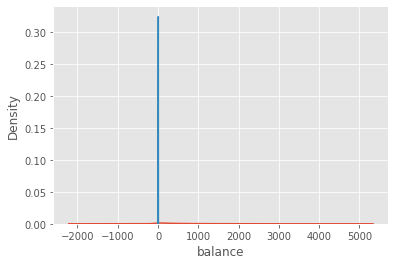

In [41]:
# Balance

# distribusi balance (nilai asli)
sns.kdeplot(df_train_clean['balance'])
# distribusi day (setelah log transformation)
sns.kdeplot(np.log(df_train_clean['balance']))
# transformasi
df_train_clean['log_balance'] = np.log(df_train_clean['balance'])
# drop kolom age (nilai asli)
#df_train_clean = df_train_clean.drop(columns='balance')

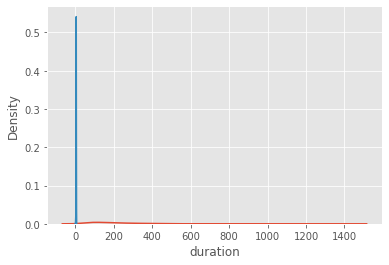

In [42]:
# Duration

# distribusi duration (nilai asli)
sns.kdeplot(df_train_clean['duration'])
# distribusi duration (setelah log transformation)
sns.kdeplot(np.log(df_train_clean['duration']))
# transformasi
df_train_clean['log_duration'] = np.log(df_train_clean['duration'])
# drop kolom age (nilai asli)
#df_train_clean = df_train_clean.drop(columns='duration')

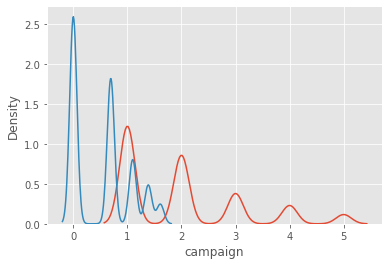

In [43]:
# Campaign

# distribusi campaign (nilai asli)
sns.kdeplot(df_train_clean['campaign'])
# distribusi campaign (setelah log transformation)
sns.kdeplot(np.log(df_train_clean['campaign']))
# transformasi
df_train_clean['log_campaign'] = np.log(df_train_clean['campaign'])
# drop kolom campaign (nilai asli)
#df = df_train_clean.drop(columns='campaign')

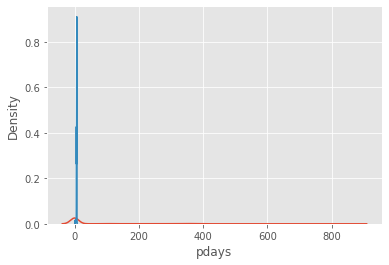

In [44]:
# Pdays

# distribusi pdays (nilai asli)
sns.kdeplot(df_train_clean['pdays'])
# distribusi pdays (setelah log transformation)
sns.kdeplot(np.log(df_train_clean['pdays']))
# transformasi
df_train_clean['log_pdays'] = np.log(df_train_clean['pdays'])
# drop kolom pdays (nilai asli)
#df_train_clean = df_train_clean.drop(columns='pdays')

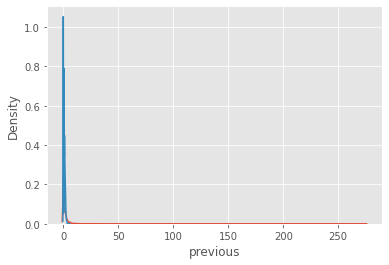

In [45]:
# Previous

# distribusi previous (nilai asli)
sns.kdeplot(df_train_clean['previous'])
# distribusi previous (setelah log transformation)
sns.kdeplot(np.log(df_train_clean['previous']))
# transformasi
df_train_clean['log_previous'] = np.log(df_train_clean['previous'])
# drop kolom previous (nilai asli)
#df_train_clean = df_train_clean.drop(columns='previous')

### F. Handle Class Imbalance

In [46]:
df_train_clean_imblance = df_train_clean.drop(["poutcome","month","contact","loan","housing","default","education","marital",
                                               "log_pdays","log_age","log_day","log_balance","log_duration","log_campaign","log_previous"], axis = 1)


In [47]:
df_train_clean_imblance.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30873 entries, 0 to 45207
Data columns (total 40 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   age                30873 non-null  int64  
 1   balance            30873 non-null  int64  
 2   day                30873 non-null  int64  
 3   duration           30873 non-null  int64  
 4   campaign           30873 non-null  int64  
 5   pdays              30873 non-null  int64  
 6   previous           30873 non-null  int64  
 7   y                  30873 non-null  int64  
 8   job_admin.         30873 non-null  uint8  
 9   job_blue-collar    30873 non-null  uint8  
 10  job_entrepreneur   30873 non-null  uint8  
 11  job_housemaid      30873 non-null  uint8  
 12  job_management     30873 non-null  uint8  
 13  job_retired        30873 non-null  uint8  
 14  job_self-employed  30873 non-null  uint8  
 15  job_services       30873 non-null  uint8  
 16  job_student        308

In [48]:
# pembuatan binary label target
df_train_clean_imblance['y_class'] = df_train_clean_imblance['n_y'] > 0
df_train_clean_imblance['y_class'].value_counts(normalize=True)

False    0.885563
True     0.114437
Name: y_class, dtype: float64

In [49]:
x = df_train_clean_imblance[[col for col in df_train_clean_imblance.columns if col not in ['y_class', 'n_y']]].values
y = df_train_clean_imblance['y_class'].values
print(x.shape)
print(y.shape)

(30873, 39)
(30873,)


In [50]:
from imblearn import under_sampling, over_sampling
X_under, y_under = under_sampling.RandomUnderSampler().fit_resample(x, y)
X_over, y_over = over_sampling.RandomOverSampler().fit_resample(x, y)
X_over_SMOTE, y_over_SMOTE = over_sampling.SMOTE().fit_resample(x, y)

In [51]:
print('Original')
print(pd.Series(y).value_counts())
print('\n')
print('UNDERSAMPLING')
print(pd.Series(y_under).value_counts())
print('\n')
print('OVERSAMPLING')
print(pd.Series(y_over).value_counts())
print('\n')
print('SMOTE')
print(pd.Series(y_over_SMOTE).value_counts())

Original
False    27340
True      3533
dtype: int64


UNDERSAMPLING
False    3533
True     3533
dtype: int64


OVERSAMPLING
False    27340
True     27340
dtype: int64


SMOTE
False    27340
True     27340
dtype: int64


## 2. Feature Enginerring

### A. Feature Selection

In [52]:
train_new = df_train_clean
train_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30873 entries, 0 to 45207
Data columns (total 55 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   age                30873 non-null  int64  
 1   marital            30873 non-null  object 
 2   education          30873 non-null  object 
 3   default            30873 non-null  object 
 4   balance            30873 non-null  int64  
 5   housing            30873 non-null  object 
 6   loan               30873 non-null  object 
 7   contact            30873 non-null  object 
 8   day                30873 non-null  int64  
 9   month              30873 non-null  object 
 10  duration           30873 non-null  int64  
 11  campaign           30873 non-null  int64  
 12  pdays              30873 non-null  int64  
 13  previous           30873 non-null  int64  
 14  poutcome           30873 non-null  object 
 15  y                  30873 non-null  int64  
 16  job_admin.         308

In [71]:
drop_col = ['log_previous','log_pdays','age','education','default','balance', 'housing', 'loan','contact', 'day','duration', 'campaign', 'pdays', 'poutcome', 'y','age_norm', 'age_std','pdays_norm', 'pdays_std', 'previous_norm','previous_std','log_day', 'log_balance', 'log_duration','log_campaign']

In [72]:
train_new_drop = train_new.drop(drop_col, axis = 1)
train_new_drop.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30873 entries, 0 to 45207
Data columns (total 30 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   marital            30873 non-null  object 
 1   month              30873 non-null  object 
 2   previous           30873 non-null  int64  
 3   job_admin.         30873 non-null  uint8  
 4   job_blue-collar    30873 non-null  uint8  
 5   job_entrepreneur   30873 non-null  uint8  
 6   job_housemaid      30873 non-null  uint8  
 7   job_management     30873 non-null  uint8  
 8   job_retired        30873 non-null  uint8  
 9   job_self-employed  30873 non-null  uint8  
 10  job_services       30873 non-null  uint8  
 11  job_student        30873 non-null  uint8  
 12  job_technician     30873 non-null  uint8  
 13  job_unemployed     30873 non-null  uint8  
 14  n_marital          30873 non-null  int64  
 15  n_education        30873 non-null  int64  
 16  n_loan             308

### B. Feature Extraction

In [73]:
train_extract = train_new_drop
train_extract.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30873 entries, 0 to 45207
Data columns (total 30 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   marital            30873 non-null  object 
 1   month              30873 non-null  object 
 2   previous           30873 non-null  int64  
 3   job_admin.         30873 non-null  uint8  
 4   job_blue-collar    30873 non-null  uint8  
 5   job_entrepreneur   30873 non-null  uint8  
 6   job_housemaid      30873 non-null  uint8  
 7   job_management     30873 non-null  uint8  
 8   job_retired        30873 non-null  uint8  
 9   job_self-employed  30873 non-null  uint8  
 10  job_services       30873 non-null  uint8  
 11  job_student        30873 non-null  uint8  
 12  job_technician     30873 non-null  uint8  
 13  job_unemployed     30873 non-null  uint8  
 14  n_marital          30873 non-null  int64  
 15  n_education        30873 non-null  int64  
 16  n_loan             308

In [74]:
def segment(x) : 
    if x['marital'] == 'married' : 
        hasil = 1
    elif x['marital'] == 'single' or x['marital'] == 'divorced'  : 
        hasil = 0
    return hasil


In [75]:
train_extract['partner'] = train_extract.apply(lambda x : segment(x), axis=1)

In [76]:
train_extract.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30873 entries, 0 to 45207
Data columns (total 31 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   marital            30873 non-null  object 
 1   month              30873 non-null  object 
 2   previous           30873 non-null  int64  
 3   job_admin.         30873 non-null  uint8  
 4   job_blue-collar    30873 non-null  uint8  
 5   job_entrepreneur   30873 non-null  uint8  
 6   job_housemaid      30873 non-null  uint8  
 7   job_management     30873 non-null  uint8  
 8   job_retired        30873 non-null  uint8  
 9   job_self-employed  30873 non-null  uint8  
 10  job_services       30873 non-null  uint8  
 11  job_student        30873 non-null  uint8  
 12  job_technician     30873 non-null  uint8  
 13  job_unemployed     30873 non-null  uint8  
 14  n_marital          30873 non-null  int64  
 15  n_education        30873 non-null  int64  
 16  n_loan             308

Feature baru ditambhkan yaitu "partner" dengan keterangan : 1 = Client memiliki status pernikahan dan 0 = Client tidak memiliki status pernikahan (single / divorce)

In [77]:
def segment(x) : 
    if x['previous'] == 0 : 
        hasil = 0
    elif x['previous'] > 0  : 
        hasil = 1
    return hasil


In [78]:
train_extract['ever_contacted'] = train_extract.apply(lambda x : segment(x), axis=1)


Feature baru ditambhkan yaitu "ever_contacted" dengan keterangan : 1 = Client telah dihubungi dan  0 = Client belum pernah dihubungi

In [79]:
train_extract.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30873 entries, 0 to 45207
Data columns (total 32 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   marital            30873 non-null  object 
 1   month              30873 non-null  object 
 2   previous           30873 non-null  int64  
 3   job_admin.         30873 non-null  uint8  
 4   job_blue-collar    30873 non-null  uint8  
 5   job_entrepreneur   30873 non-null  uint8  
 6   job_housemaid      30873 non-null  uint8  
 7   job_management     30873 non-null  uint8  
 8   job_retired        30873 non-null  uint8  
 9   job_self-employed  30873 non-null  uint8  
 10  job_services       30873 non-null  uint8  
 11  job_student        30873 non-null  uint8  
 12  job_technician     30873 non-null  uint8  
 13  job_unemployed     30873 non-null  uint8  
 14  n_marital          30873 non-null  int64  
 15  n_education        30873 non-null  int64  
 16  n_loan             308

In [80]:
def segment(x) : 
    if x['month'] == 'nov' or x['month'] == 'oct' or x['month'] == 'jan' or x['month'] == 'feb' or x['month'] == 'mar' : 
        hasil = 0
    elif x['month'] == 'apr' or x['month'] == 'may' or x['month'] == 'jun' or x['month'] == 'jul' or x['month'] == 'aug' or x['month'] == 'sep' or x['month'] == 'dec'  : 
        hasil = 1
    return hasil

In [81]:
train_extract['high_season'] =train_extract.apply(lambda x : segment(x), axis=1)

Feature baru ditambhkan yaitu "High_season" dengan keterangan : 1 = High season dan 0 = low season dimana high season terjadi diantara bulan april hingga september sedangkan low season terjadi di bulan november hingga bulan maret kecuali bulan Desember yang masuk ke dalam high season

In [82]:
from matplotlib import rcParams

rcParams['figure.figsize'] = 15, 9
rcParams['lines.linewidth'] = 6
rcParams['xtick.labelsize'] = 'x-large'
rcParams['ytick.labelsize'] = 'x-large'

In [83]:
train_extract = train_extract.drop(['month','previous'], axis = 1)

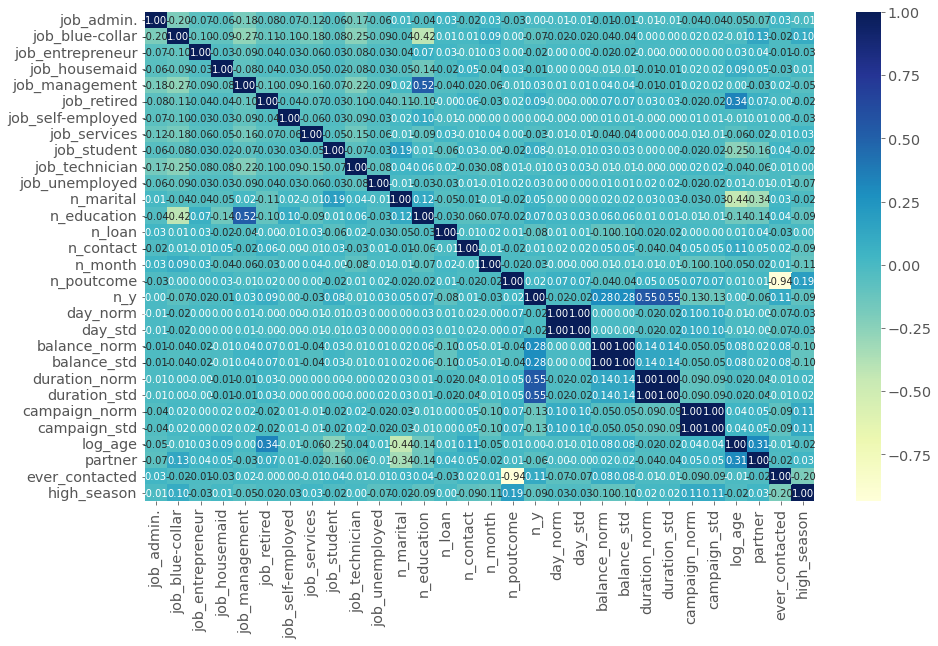

In [84]:
sns.heatmap(train_extract.corr(), cmap='YlGnBu', annot=True, fmt='.2f')

In [85]:
train_extract = train_extract.drop(['n_poutcome'], axis = 1)

In [86]:
drop_job = ['job_admin.','job_blue-collar', 'job_entrepreneur','job_housemaid', 'job_management', 'job_retired', 'job_self-employed','job_services', 'job_student', 'job_technician', 'job_unemployed']

In [87]:
train_no_job = train_extract.drop(drop_job, axis = 1)

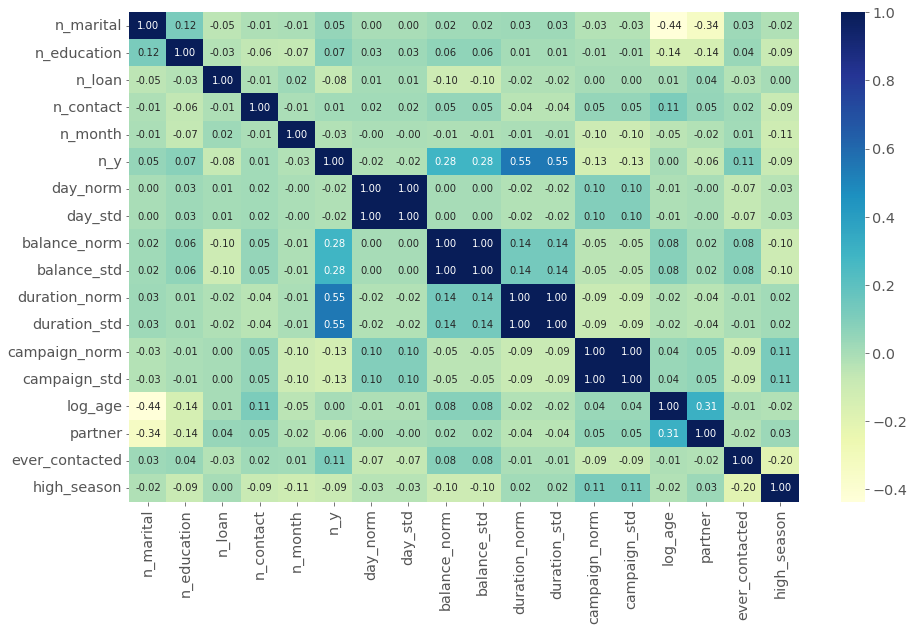

In [88]:
sns.heatmap(train_no_job.corr(), cmap='YlGnBu', annot=True, fmt='.2f')